# Modification of Google's "Post-training integer quantization"

## Overview

This is a modifcation of Google's example code for testing the following issues:

- ["model not quantized" error](https://colab.research.google.com/github/google-coral/tutorials/blob/master/fix_conversion_issues_ptq_tf2.ipynb)

  - if converter.experimental_new_converter = True (which is default) and model.input.shape contains
    "None", quantized models do not compile for edgetpu
    
  - replace "None" by 1
  
  
- slow interpreter.set_tensor:

  - depending on the input data type, interpreter.set_tensor becomes extremely slow
  
  - workaround: use np.array for input (not sure it works in all cases)

## Setup

In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 


import tensorflow as tf
import numpy as np
assert float(tf.__version__[:3]) >= 2.3

import matplotlib.pyplot as plt

import time
from datetime import datetime

import tensorboard
%load_ext tensorboard

## Generate a TensorFlow Model

We'll build a simple model to classify numbers from the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist).

In [2]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

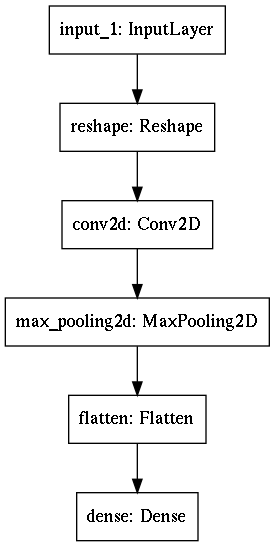

In [3]:
tf.keras.utils.plot_model(model)

## Define the Keras TensorBoard callback.

In [4]:
#logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#model.fit(
#  train_images,
#  train_labels,
#  epochs=5,
#  validation_data=(test_images, test_labels),
#  callbacks=[tensorboard_callback]
#)

#%tensorboard --logdir logs

# Workaround for bug caused by dynamic batch size

In [5]:
model.input.shape

TensorShape([None, 28, 28])

In [6]:
# https://colab.research.google.com/github/google-coral/tutorials/blob/master/fix_conversion_issues_ptq_tf2.ipynb#scrollTo=1_ViBvedQ6SK

model.input.set_shape((1,) + model.input.shape[1:])

In [7]:
model.input.shape

TensorShape([1, 28, 28])

# Convert to TFLite

## No quant

In [8]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter.experimental_new_converter = True

mnist = converter.convert()

with open('mnist.tflite', 'wb') as f:
    f.write(mnist)
    
! edgetpu_compiler mnist.tflite

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpx5e_lfmt/assets
Edge TPU Compiler version 15.0.340273435
Invalid model: mnist.tflite
Model not quantized


This is ok, since the model actually *is not quantized*

## Dyn quant

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

mnist_dyn = converter.convert()

with open('mnist_dyn.tflite', 'wb') as f:
    f.write(mnist_dyn)
    
! edgetpu_compiler mnist_dyn.tflite

INFO:tensorflow:Assets written to: /tmp/tmpz2rj3xl8/assets


INFO:tensorflow:Assets written to: /tmp/tmpz2rj3xl8/assets


Edge TPU Compiler version 15.0.340273435
Invalid model: mnist_dyn.tflite
Model not quantized


This is ok, since the model actually *is not quantized*

## Dyn quant fio

In [10]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

#converter.experimental_new_converter = False # is only needen without workaround above


converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

mnist_fio = converter.convert()


with open('mnist_fio.tflite', 'wb') as f:
    f.write(mnist_fio)
    
! edgetpu_compiler mnist_fio.tflite
! ls -l mnist_fio*

INFO:tensorflow:Assets written to: /tmp/tmp_maw6wq6/assets


INFO:tensorflow:Assets written to: /tmp/tmp_maw6wq6/assets


Edge TPU Compiler version 15.0.340273435

Model compiled successfully in 28 ms.

Input model: mnist_fio.tflite
Input size: 23.02KiB
Output model: mnist_fio_edgetpu.tflite
Output size: 96.79KiB
On-chip memory used for caching model parameters: 130.00KiB
On-chip memory remaining for caching model parameters: 7.73MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 7
Operation log: mnist_fio_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 5
Number of operations that will run on CPU: 2
See the operation log file for individual operation details.
-rw-rw-r-- 1 mre mre   610 Dez  7 10:35 mnist_fio_edgetpu.log
-rw-rw-r--

## Dyn quant int

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

#converter.experimental_new_converter = False


# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

mnist_int = converter.convert()


with open('mnist_int.tflite', 'wb') as f:
    f.write(mnist_int)
    
! edgetpu_compiler mnist_int.tflite
! ls -l mnist_int_*

INFO:tensorflow:Assets written to: /tmp/tmp07swsr39/assets


INFO:tensorflow:Assets written to: /tmp/tmp07swsr39/assets


Edge TPU Compiler version 15.0.340273435

Model compiled successfully in 30 ms.

Input model: mnist_int.tflite
Input size: 23.09KiB
Output model: mnist_int_edgetpu.tflite
Output size: 96.52KiB
On-chip memory used for caching model parameters: 134.00KiB
On-chip memory remaining for caching model parameters: 7.72MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 7
Operation log: mnist_int_edgetpu.log
See the operation log file for individual operation details.
-rw-rw-r-- 1 mre mre   454 Dez  7 10:35 mnist_int_edgetpu.log
-rw-rw-r-- 1 mre mre 98840 Dez  7 10:35 mnist_int_edgetpu.tflite


# Run full model

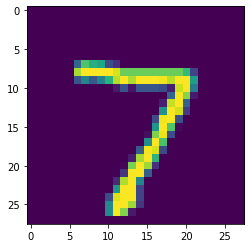

In [13]:
#x = test_images[:3]
x = test_images[:100]

plt.imshow(x[0]);

In [14]:
x0 = x[0].reshape(1, *x[0].shape)
x0.shape

(1, 28, 28)

In [15]:
%timeit model.predict(x0)

18.4 ms ± 779 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Run TFLite models

In [16]:
import platform
import tflite_runtime.interpreter as tflite

EDGETPU_SHARED_LIB = {
  'Linux': 'libedgetpu.so.1',
  'Darwin': 'libedgetpu.1.dylib',
  'Windows': 'edgetpu.dll'
}[platform.system()]


def edge_interpreter(model_file):
  model_file, *device = model_file.split('@')
  return tflite.Interpreter(
      model_path=model_file,
      experimental_delegates=[
          tflite.load_delegate(EDGETPU_SHARED_LIB,
                               {'device': device[0]} if device else {})
      ])

In [17]:
def run(interpreter, xx):
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    interpreter.allocate_tensors()

    yy = []
    for x in xx:
        interpreter.set_tensor(input_details["index"], [x])
        interpreter.invoke()
        y = interpreter.get_tensor(output_details["index"])[0]

        yy.append(y.argmax())
    return yy


def repeat(interpreter, xx, nrep = 10000):
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    interpreter.allocate_tensors()

    yy = []
    for x in xx:
        interpreter.set_tensor(input_details["index"], [x])
        
        start = time.perf_counter()
        for i in range(nrep):
            interpreter.invoke()
        inference_time = time.perf_counter() - start
        print('%.1fms' % (inference_time * 1000))    
        
        y = interpreter.get_tensor(output_details["index"])[0]

        yy.append(y.argmax())
    return yy


def toUint8(interpreter, xx):
    s, c =interpreter.get_input_details()[0]['quantization']
    x8 = tf.cast(tf.round(x/s + c), dtype=tf.uint8)
    return x8

## No quant

In [18]:
type(x)

numpy.ndarray

In [19]:
interpreter = tflite.Interpreter(model_path='mnist.tflite')

%timeit run(interpreter, x)[-1]

13.3 ms ± 247 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%time repeat(interpreter, [x[0]])

1313.6ms
CPU times: user 1.31 s, sys: 0 ns, total: 1.31 s
Wall time: 1.31 s


[0]

## Dyn quant

In [21]:
interpreter = tflite.Interpreter(model_path='mnist_dyn.tflite')

%timeit run(interpreter, x)[-1]

14 ms ± 32.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%time repeat(interpreter, [x[0]])

1344.4ms
CPU times: user 1.34 s, sys: 0 ns, total: 1.34 s
Wall time: 1.34 s


[0]

## Dyn quant fio

In [23]:
interpreter = tflite.Interpreter(model_path='mnist_fio.tflite')
interpreter.get_input_details()

[{'name': 'input_1',
  'index': 12,
  'shape': array([ 1, 28, 28], dtype=int32),
  'shape_signature': array([ 1, 28, 28], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [24]:
type(x), x.shape, x.dtype

(numpy.ndarray, (100, 28, 28), dtype('float32'))

In [25]:
%timeit run(interpreter, x)[-1]

4.11 ms ± 63.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%time repeat(interpreter, [x[0]])

349.4ms
CPU times: user 350 ms, sys: 0 ns, total: 350 ms
Wall time: 349 ms


[0]

## Dyn quant int

In [27]:
interpreter = tflite.Interpreter(model_path='mnist_int.tflite')
interpreter.get_input_details()

[{'name': 'input_1',
  'index': 12,
  'shape': array([ 1, 28, 28], dtype=int32),
  'shape_signature': array([ 1, 28, 28], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.003921568859368563, 0),
  'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

### Slow if input ist tensor

In [28]:
x8 = toUint8(interpreter, x)#.numpy()

type(x8), x8.shape, x8.dtype

(tensorflow.python.framework.ops.EagerTensor,
 TensorShape([100, 28, 28]),
 tf.uint8)

In [29]:
%time run(interpreter, x8)[-1]

CPU times: user 4.05 s, sys: 0 ns, total: 4.05 s
Wall time: 4.05 s


9

### Fast if input ist np.array

In [30]:
x8 = toUint8(interpreter, x).numpy()

type(x8), x8.shape, x8.dtype

(numpy.ndarray, (100, 28, 28), dtype('uint8'))

In [31]:
%time run(interpreter, x8)[-1]

CPU times: user 4.48 ms, sys: 0 ns, total: 4.48 ms
Wall time: 4.3 ms


9

In [32]:
%timeit run(interpreter, x8)[-1]

4.1 ms ± 31 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
%time repeat(interpreter, [x8[0]])

367.7ms
CPU times: user 368 ms, sys: 0 ns, total: 368 ms
Wall time: 368 ms


[0]

## Dyn quant fio edge

In [34]:
interpreter = edge_interpreter("mnist_fio_edgetpu.tflite")

%timeit run(interpreter, x)[-1]

15.9 ms ± 291 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
%time repeat(interpreter, [x[0]])

1524.1ms
CPU times: user 413 ms, sys: 98.6 ms, total: 512 ms
Wall time: 1.52 s


[0]

## Dyn quant int edge

In [36]:
interpreter = edge_interpreter("mnist_int_edgetpu.tflite")

x8 = toUint8(interpreter, x).numpy()

type(x8), x8.shape, x8.dtype

(numpy.ndarray, (100, 28, 28), dtype('uint8'))

In [37]:
%timeit run(interpreter, x8)[-1]

14.7 ms ± 391 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
%time repeat(interpreter, [x8[0]])

1379.4ms
CPU times: user 281 ms, sys: 66.6 ms, total: 347 ms
Wall time: 1.38 s


[0]